# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.62KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

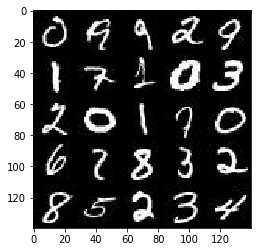

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

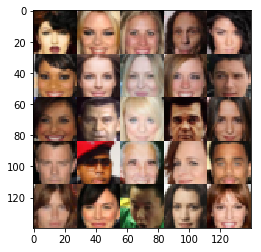

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [63]:
ALPHA = 0.2

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        layer_1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        layer_1 = tf.maximum(ALPHA * layer_1, layer_1)
        
        layer_2 = tf.layers.conv2d(layer_1, 112, 5, strides=2, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(ALPHA * layer_2, layer_2)
        
        layer_3 = tf.layers.conv2d(layer_2, 224, 5, strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(ALPHA * layer_2, layer_2)
        
        flatten = tf.reshape(layer_3, (-1, 7*7*224))
        
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [64]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # First fully connected layer
    with tf.variable_scope('generator', reuse=not is_train):
        layer_1 = tf.layers.dense(z, 7*7*112)

        # Reshape the layer to get first image sizes
        layer_1 = tf.reshape(layer_1, (-1, 7, 7, 112))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(ALPHA * layer_1, layer_1)

        layer_2 = tf.layers.conv2d_transpose(layer_1, 56, 5, strides=2, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(ALPHA * layer_2, layer_2)

        # Output layer, 28x328x3
        logits = tf.layers.conv2d_transpose(layer_2, out_channel_dim, 5, strides=2, padding='same')

        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [65]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function\
    ## Generator model
    g_model = generator(input_z, out_channel_dim)
    
    # Dicriminator model and logits
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)   
    
    # Generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # Discriminator losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_fake)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [66]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get trainable variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [68]:
PRINT_EVERY = 20
SHOW_IMAGES_EVERY = 100
SHOW_IMAGES_COUNT = 9

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    
    output_channel_dim = data_shape[-1]
    
    inputs_real, inputs_z, lr = model_inputs(*data_shape[1:], z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, output_channel_dim)
    d_opt,  g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Normalize images
                batch_images = batch_images * 2.0
                
                # Running optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                
                if steps % PRINT_EVERY == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % SHOW_IMAGES_EVERY == 0:
                    show_generator_output(sess, SHOW_IMAGES_COUNT, inputs_z, output_channel_dim, data_image_mode)       
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2759... Generator Loss: 1.7205
Epoch 1/2... Discriminator Loss: 0.3374... Generator Loss: 2.2647
Epoch 1/2... Discriminator Loss: 0.2870... Generator Loss: 2.6690
Epoch 1/2... Discriminator Loss: 0.2843... Generator Loss: 1.9941
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 0.8014


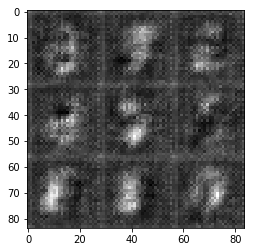

Epoch 1/2... Discriminator Loss: 0.4838... Generator Loss: 2.4710
Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 2.2416
Epoch 1/2... Discriminator Loss: 0.5362... Generator Loss: 1.2053
Epoch 1/2... Discriminator Loss: 0.5173... Generator Loss: 1.5341
Epoch 1/2... Discriminator Loss: 0.5639... Generator Loss: 1.7030


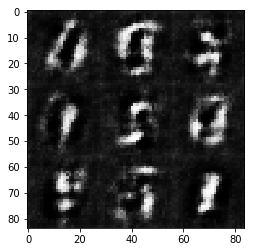

Epoch 1/2... Discriminator Loss: 0.6120... Generator Loss: 2.1613
Epoch 1/2... Discriminator Loss: 0.5412... Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 0.6443... Generator Loss: 1.7053
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.3524
Epoch 1/2... Discriminator Loss: 0.7099... Generator Loss: 1.8983


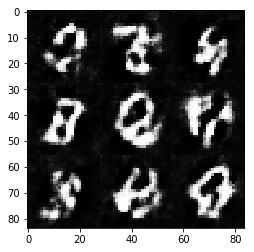

Epoch 1/2... Discriminator Loss: 0.6219... Generator Loss: 1.3928
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 0.9267
Epoch 1/2... Discriminator Loss: 0.6159... Generator Loss: 1.5729
Epoch 1/2... Discriminator Loss: 0.7008... Generator Loss: 1.7646
Epoch 1/2... Discriminator Loss: 0.6353... Generator Loss: 1.1632


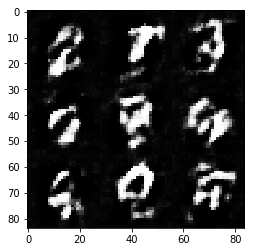

Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 1.1567
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 1.6463
Epoch 1/2... Discriminator Loss: 0.6534... Generator Loss: 1.4270
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 1.4876
Epoch 1/2... Discriminator Loss: 0.5846... Generator Loss: 1.1132


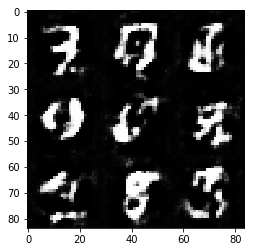

Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 1.7659
Epoch 1/2... Discriminator Loss: 0.4270... Generator Loss: 1.7114
Epoch 1/2... Discriminator Loss: 0.5685... Generator Loss: 1.9361
Epoch 1/2... Discriminator Loss: 0.5400... Generator Loss: 1.4979
Epoch 1/2... Discriminator Loss: 0.5749... Generator Loss: 2.2034


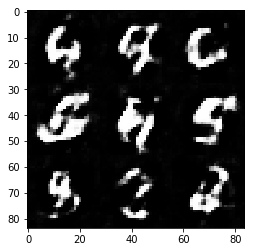

Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 1.1788
Epoch 1/2... Discriminator Loss: 0.4219... Generator Loss: 1.7172
Epoch 1/2... Discriminator Loss: 0.4364... Generator Loss: 2.2503
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 0.3731... Generator Loss: 2.0377


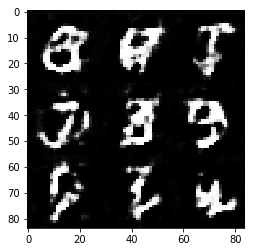

Epoch 1/2... Discriminator Loss: 0.4358... Generator Loss: 1.5503
Epoch 1/2... Discriminator Loss: 0.4782... Generator Loss: 1.3266
Epoch 1/2... Discriminator Loss: 0.6033... Generator Loss: 1.2686
Epoch 1/2... Discriminator Loss: 0.3899... Generator Loss: 1.7886
Epoch 1/2... Discriminator Loss: 0.4425... Generator Loss: 1.3643


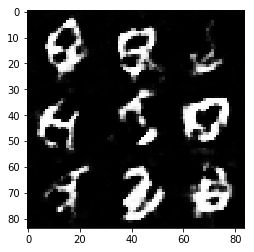

Epoch 1/2... Discriminator Loss: 0.3531... Generator Loss: 1.8961
Epoch 1/2... Discriminator Loss: 0.4588... Generator Loss: 2.2314
Epoch 1/2... Discriminator Loss: 0.3536... Generator Loss: 1.6693
Epoch 1/2... Discriminator Loss: 0.4561... Generator Loss: 1.4022
Epoch 1/2... Discriminator Loss: 0.4536... Generator Loss: 1.5495


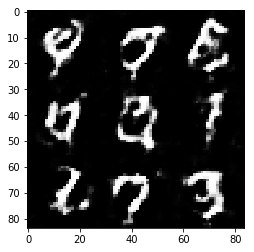

Epoch 1/2... Discriminator Loss: 0.3185... Generator Loss: 2.3380
Epoch 2/2... Discriminator Loss: 0.3734... Generator Loss: 1.5449
Epoch 2/2... Discriminator Loss: 0.5782... Generator Loss: 0.9940
Epoch 2/2... Discriminator Loss: 0.4379... Generator Loss: 1.6317
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 2.1046


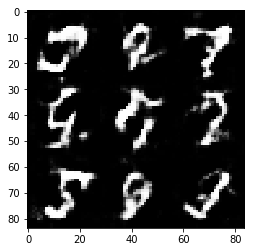

Epoch 2/2... Discriminator Loss: 0.3383... Generator Loss: 1.9104
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 3.2259
Epoch 2/2... Discriminator Loss: 0.3641... Generator Loss: 2.2493
Epoch 2/2... Discriminator Loss: 0.7136... Generator Loss: 1.0538
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 1.7762


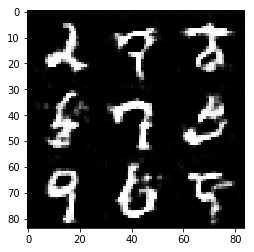

Epoch 2/2... Discriminator Loss: 0.6554... Generator Loss: 2.1154
Epoch 2/2... Discriminator Loss: 0.5661... Generator Loss: 1.1627
Epoch 2/2... Discriminator Loss: 0.4851... Generator Loss: 1.9897
Epoch 2/2... Discriminator Loss: 0.4870... Generator Loss: 1.7065
Epoch 2/2... Discriminator Loss: 0.5110... Generator Loss: 1.4220


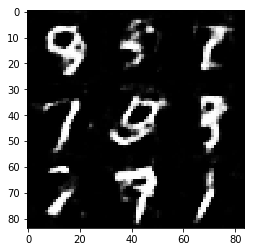

Epoch 2/2... Discriminator Loss: 0.4990... Generator Loss: 1.9042
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 2.2355
Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 2.4459
Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 1.5133
Epoch 2/2... Discriminator Loss: 0.7070... Generator Loss: 0.9008


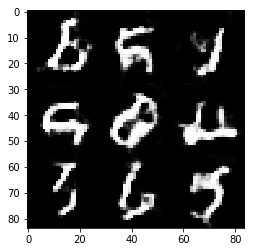

Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.0085
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.1852
Epoch 2/2... Discriminator Loss: 0.4893... Generator Loss: 2.2450
Epoch 2/2... Discriminator Loss: 0.8385... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 0.4734... Generator Loss: 1.7193


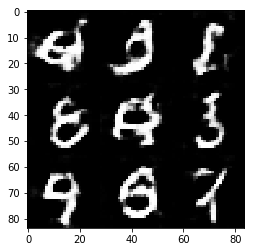

Epoch 2/2... Discriminator Loss: 0.6465... Generator Loss: 1.7213
Epoch 2/2... Discriminator Loss: 0.5039... Generator Loss: 1.3953
Epoch 2/2... Discriminator Loss: 0.4847... Generator Loss: 1.6133
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 2.5246
Epoch 2/2... Discriminator Loss: 0.6120... Generator Loss: 1.4120


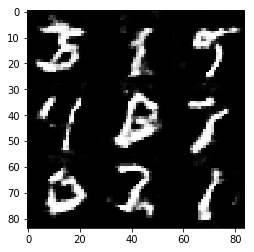

Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 1.5311
Epoch 2/2... Discriminator Loss: 0.4726... Generator Loss: 1.6999
Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 1.1744
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 2.4010
Epoch 2/2... Discriminator Loss: 0.6009... Generator Loss: 1.1656


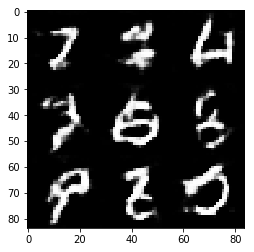

Epoch 2/2... Discriminator Loss: 0.5420... Generator Loss: 1.8931
Epoch 2/2... Discriminator Loss: 0.4322... Generator Loss: 1.6501
Epoch 2/2... Discriminator Loss: 0.5561... Generator Loss: 1.2192
Epoch 2/2... Discriminator Loss: 2.7106... Generator Loss: 4.9703
Epoch 2/2... Discriminator Loss: 0.5793... Generator Loss: 1.4465


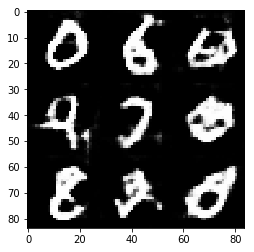

Epoch 2/2... Discriminator Loss: 0.6766... Generator Loss: 1.7219
Epoch 2/2... Discriminator Loss: 0.7379... Generator Loss: 1.9554
Epoch 2/2... Discriminator Loss: 0.5241... Generator Loss: 1.7180
Epoch 2/2... Discriminator Loss: 0.5402... Generator Loss: 1.3647
Epoch 2/2... Discriminator Loss: 0.5885... Generator Loss: 1.2576


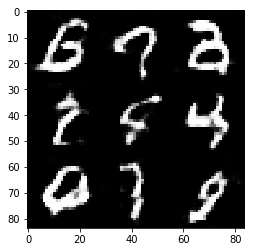

Epoch 2/2... Discriminator Loss: 0.5750... Generator Loss: 1.0864
Epoch 2/2... Discriminator Loss: 0.5989... Generator Loss: 1.0674
Epoch 2/2... Discriminator Loss: 0.4719... Generator Loss: 1.9640


In [69]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 1.6139
Epoch 1/1... Discriminator Loss: 0.2770... Generator Loss: 2.0645
Epoch 1/1... Discriminator Loss: 0.2264... Generator Loss: 2.7343
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 1.5917


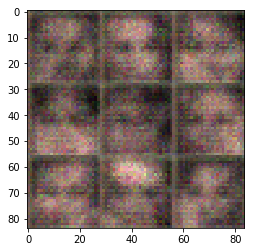

Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 1.2407
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 1.5821
Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 1.5094
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 2.1876
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 1.0783


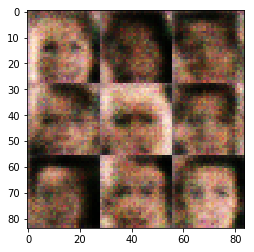

Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 1.2179
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 1.6434
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.8480
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.8271


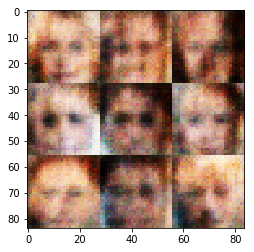

Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.6890
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.6434


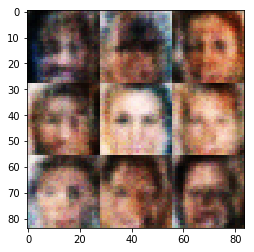

Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.3790
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.4324
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 0.7933


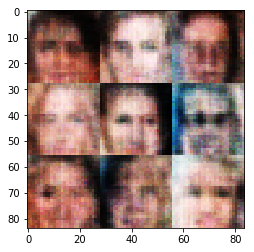

Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 1.5272
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 1.1534


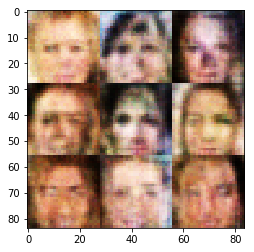

Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 1.1944
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.4807
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.3837


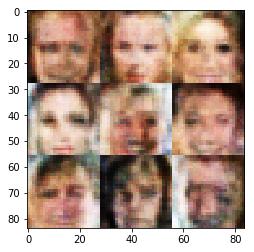

Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.4017
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.5769


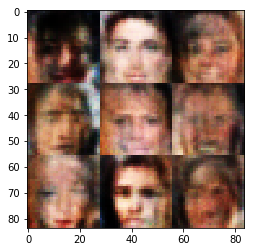

Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.1389
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.1301


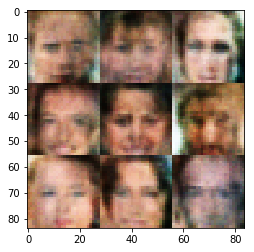

Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.3665


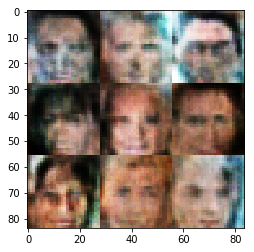

Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.6717


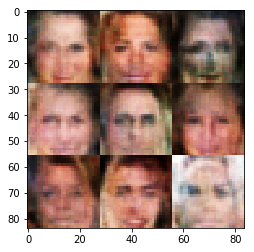

Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.7960


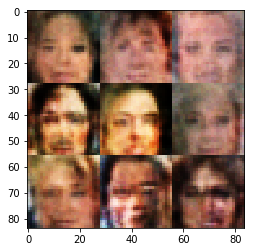

Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7947


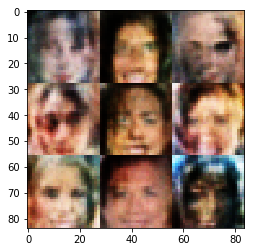

Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.1467


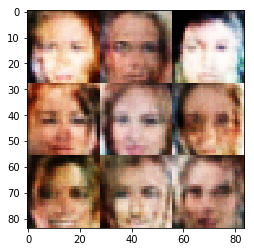

Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8354


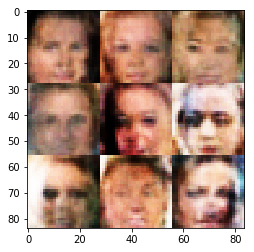

Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.6362


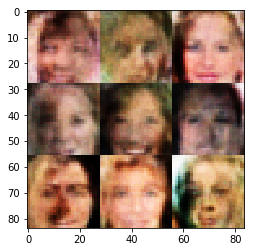

Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.5790


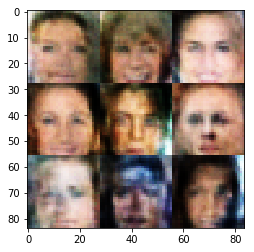

Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.9158


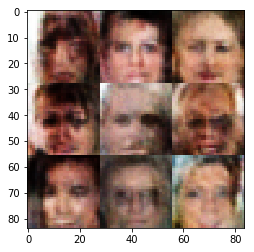

Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.1609


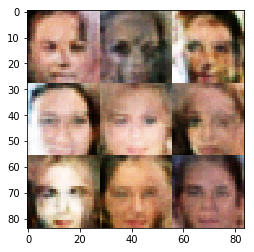

Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 0.9624


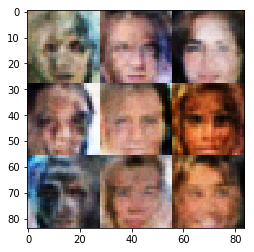

Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.8441


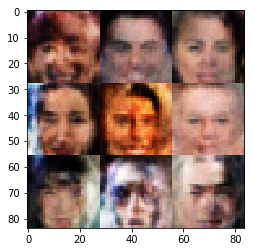

Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.2288


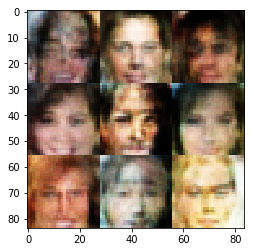

Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.0772


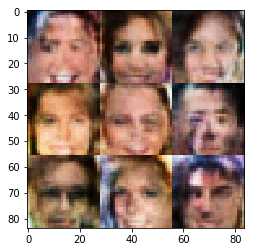

Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.4900


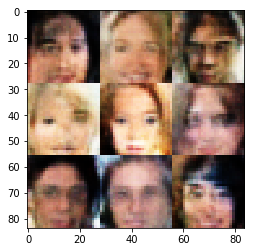

Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 0.8255


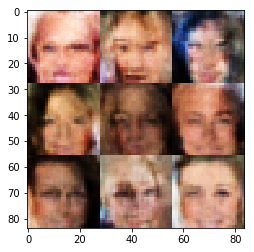

Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.0107


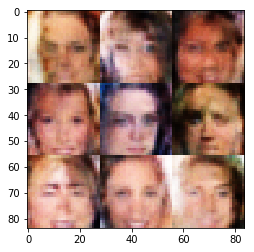

Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.4233


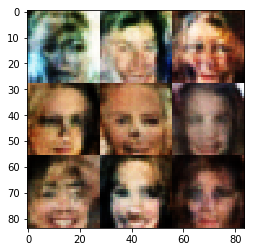

Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.3851
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.7265


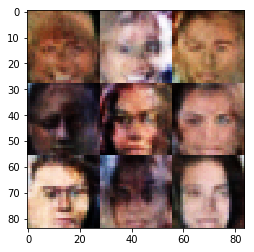

Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.5603


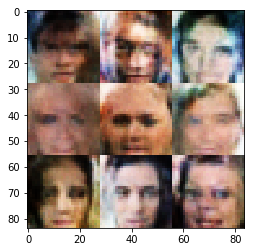

Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 0.9058


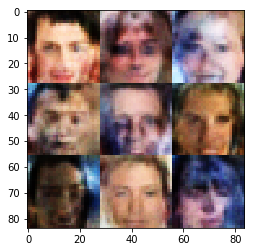

Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.3542
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7697


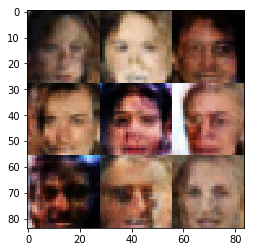

Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.6207


In [70]:
batch_size    = 64
z_dim         = 100
learning_rate = 0.0002
beta1         = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.